In [1]:
import json
import pandas as pd
import numpy as np
import os
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display, HTML

In [2]:
# Set the display option
pd.set_option('display.expand_frame_repr', False)

data_file = 'data/Sample data.json'
clean_file = 'data/clean_data.json'

In [3]:
# Check if the file exists
if os.path.exists(data_file):
    # Try to load and parse the JSON in the file
    try:
        with open(data_file, 'r') as f:
            data = json.load(f)
        df = pd.DataFrame(data)
    except Exception as e:
        print(f"An error occurred: {type(e).__name__}, {str(e)}")
        print(f"Attempting to clean the data...")
        with open(data_file, 'r') as f:
            data = f.read()
        # Replace single quotes with double quotes
        data = data.replace("'", '"')
        # Write the result back to the file
        with open(clean_file, 'w') as f:
            f.write(data)
        print(f"Cleaned data written to {clean_file}.")
else:
    print(f"The file {data_file} does not exist.")



An error occurred: JSONDecodeError, Expecting property name enclosed in double quotes: line 3 column 4 (char 8)
Attempting to clean the data...
Cleaned data written to data/clean_data.json.


# Data Cleaning  

In [4]:
# Load data
df = pd.read_json(clean_file)

display(df.head(10))

# Get the first row of the DataFrame
first_row = df.iloc[0]

# Create a dictionary mapping the old column names to the new ones
column_mapping = {f'Response {i+1}': first_row[f'Response {i+1}'] for i in range(5)}

# Rename the columns
df.rename(columns=column_mapping, inplace=True)

# Drop the first row
df.drop(df.index[0], inplace=True)

# add year column
df['Year'] = df['Question level 2'].str.extract('(\d{4})')
# Convert 'Year' to datetime format
df['Year'] = pd.to_datetime(df['Year'], format='%Y').dt.year

# add period description column
df['Period'] = df['Question level 2'].str.extract('([A-Za-z\s]+)')
df['Period'] = df['Period'].str.strip()
# Fill empty 'Period' cells with 'EoY'
df['Period'] = df['Period'].fillna('EoY')
# Capitalize all values in 'Period' column
df['Period'] = df['Period'].str.upper()

# Reset the index
df.reset_index(drop=True, inplace=True)
# drop EoY 2024 in 'Question level 2' columns as EoY 2024 is not a valid value in the real world scenario
df = df[df['Question level 2'] != 'EoY 2024']

df.drop(columns=['Project', 'Question level 2'], inplace=True)

# Rename the column
df = df.rename(columns={
                        'Question level 1': 'Category',
                        'Question level 3': 'Subcategory'
                        })
# Define a dictionary for the replacements
replacements = {
    'What was your AuM split over the last 5 years?': 'AUM Split',
    'What was your revenue in the last 5 years?': 'Revenue',
    'What was your total AuM in the last 5 years?': 'AUM'
}

# Replace the values
df['Category'] = df['Category'].replace(replacements)

# Convert responses to numeric
columns = ['Company A', 'Company B', 'Company C', 'Company D', 'Company E']
df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')
df[columns] = df[columns].round(0)

# Fill NaN values with 0
df.fillna(0, inplace=True)



print('')
display(df.head(10))



,Project,Question level 1,Question level 2,Question level 3,Response 1,Response 2,Response 3,Response 4,Response 5
0,Alpha,What is your IMC name?,,,Company A,Company B,Company C,Company D,Company E
1,Alpha,What was your total AuM in the last 5 years?,EoY 2020,Total,,3550,6000,6857,
2,Alpha,What was your total AuM in the last 5 years?,EoY 2021,Total,,3710,6211,6843,5138
3,Alpha,What was your total AuM in the last 5 years?,EoY 2022,Total,,3940,9358,6737,5698
4,Alpha,What was your total AuM in the last 5 years?,EoY 2023,Total,,4060,6521,6827,5745
5,Alpha,What was your total AuM in the last 5 years?,EoY 2024,Total,,4251,6755,7201,5717
6,Alpha,What was your total AuM in the last 5 years?,YTD 31 March 2024,Total,,4275.719606,6848.917068,7629.398584,5617
7,Alpha,What was your AuM split over the last 5 years?,EoY 2020,Fixed income,1000,600,2500,1010,
8,Alpha,What was your AuM split over the last 5 years?,EoY 2020,Hedge funds,400,300,450,790,
9,Alpha,What was your AuM split over the last 5 years?,EoY 2020,Multi-asset,800,950,1000,300,


,Category,Subcategory,Company A,Company B,Company C,Company D,Company E,Year,Period
0,AUM,Total,0.0,3550.0,6000.0,6857.0,0.0,2020,EOY
1,AUM,Total,0.0,3710.0,6211.0,6843.0,5138.0,2021,EOY
2,AUM,Total,0.0,3940.0,9358.0,6737.0,5698.0,2022,EOY
3,AUM,Total,0.0,4060.0,6521.0,6827.0,5745.0,2023,EOY
5,AUM,Total,0.0,4276.0,6849.0,7629.0,5617.0,2024,YTD
6,AUM Split,Fixed income,1000.0,600.0,2500.0,1010.0,0.0,2020,EOY
7,AUM Split,Hedge funds,400.0,300.0,450.0,790.0,0.0,2020,EOY
8,AUM Split,Multi-asset,800.0,950.0,1000.0,300.0,0.0,2020,EOY
9,AUM Split,Other,300.0,250.0,350.0,380.0,0.0,2020,EOY
10,AUM Split,Private Debt,700.0,0.0,200.0,920.0,0.0,2020,EOY


## Melt

In [5]:
# melt the DataFrame
df_melted = pd.melt(df, 
                    id_vars=['Year', 'Period', 'Category', 'Subcategory'],
                    var_name='Company', 
                    value_name='Value')

# Display the first 10 rows of the melted DataFrame
display(df_melted.head(10))

,Year,Period,Category,Subcategory,Company,Value
0,2020,EOY,AUM,Total,Company A,0.0
1,2021,EOY,AUM,Total,Company A,0.0
2,2022,EOY,AUM,Total,Company A,0.0
3,2023,EOY,AUM,Total,Company A,0.0
4,2024,YTD,AUM,Total,Company A,0.0
5,2020,EOY,AUM Split,Fixed income,Company A,1000.0
6,2020,EOY,AUM Split,Hedge funds,Company A,400.0
7,2020,EOY,AUM Split,Multi-asset,Company A,800.0
8,2020,EOY,AUM Split,Other,Company A,300.0
9,2020,EOY,AUM Split,Private Debt,Company A,700.0


## Pivot

In [6]:
#pivot the DataFrame
df_pivot = df_melted.pivot_table(index=['Company','Year'],
                                 columns=['Category','Subcategory'],
                                 values='Value').reset_index()
                               
# Flatten the MultiIndex in columns
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]


# Display the first 10 rows of the pivoted DataFrame
display(df_pivot.head(10))

,Company_,Year_,AUM_Total,AUM Split_Fixed income,AUM Split_Hedge funds,AUM Split_Multi-asset,AUM Split_Other,AUM Split_Private Debt,AUM Split_Private Equity,AUM Split_Public equities,Revenue_Total
0,Company A,2020,0.0,1000.0,400.0,800.0,300.0,700.0,600.0,500.0,3569.0
1,Company A,2021,0.0,1050.0,410.0,820.0,310.0,720.0,620.0,520.0,3797.0
2,Company A,2022,0.0,1100.0,420.0,840.0,320.0,740.0,640.0,540.0,4035.0
3,Company A,2023,0.0,1150.0,430.0,860.0,330.0,760.0,800.0,560.0,4409.0
4,Company A,2024,0.0,1213.0,657.0,885.0,343.0,785.0,1047.0,585.0,4835.0
5,Company B,2020,3550.0,600.0,300.0,950.0,250.0,0.0,750.0,700.0,2662.0
6,Company B,2021,3710.0,650.0,310.0,980.0,260.0,0.0,780.0,730.0,2866.0
7,Company B,2022,3940.0,780.0,320.0,1010.0,270.0,0.0,800.0,760.0,3135.0
8,Company B,2023,4060.0,800.0,330.0,1040.0,280.0,0.0,820.0,790.0,3327.0
9,Company B,2024,4276.0,903.0,341.0,1074.0,291.0,0.0,843.0,824.0,3588.0


# Calculations

### Check for Outliers

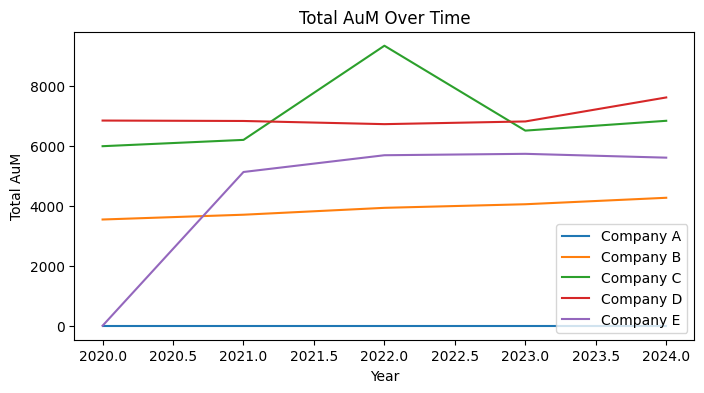


Company C data:


,AUM_Total,AUM Split_Fixed income,AUM Split_Hedge funds,AUM Split_Multi-asset,AUM Split_Other,AUM Split_Private Debt,AUM Split_Private Equity,AUM Split_Public equities,Revenue_Total
Year_,,,,,,,,,
2020,6000.0,2500.0,450.0,1000.0,350.0,200.0,800.0,600.0,3900.0
2021,6211.0,2551.0,460.0,1020.0,360.0,230.0,830.0,630.0,4199.0
2022,9358.0,5543.0,470.0,1040.0,370.0,219.0,860.0,650.0,6579.0
2023,6521.0,2531.0,480.0,1060.0,380.0,190.0,890.0,670.0,4768.0
2024,6849.0,2499.0,495.0,1090.0,395.0,195.0,935.0,700.0,5137.0



Company E data:


,AUM_Total,AUM Split_Fixed income,AUM Split_Hedge funds,AUM Split_Multi-asset,AUM Split_Other,AUM Split_Private Debt,AUM Split_Private Equity,AUM Split_Public equities,Revenue_Total
Year_,,,,,,,,,
2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021,5138.0,0.0,1408.0,0.0,330.0,0.0,2760.0,640.0,4316.0
2022,5698.0,0.0,1397.0,0.0,340.0,0.0,3301.0,660.0,4963.0
2023,5745.0,0.0,1290.0,0.0,350.0,0.0,3425.0,680.0,5189.0
2024,5617.0,0.0,748.0,0.0,360.0,0.0,3809.0,700.0,5355.0


In [7]:
# line chart
fig, ax = plt.subplots(figsize=(8, 4))
for company in df_pivot['Company_'].unique():
    df_temp = df_pivot[df_pivot['Company_'] == company]
    ax.plot(df_temp['Year_'], df_temp['AUM_Total'], label=company)
ax.set_title('Total AuM Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Total AuM')
ax.legend()
plt.show()

# table with company C data
df_company_c = df_pivot[df_pivot['Company_'] == 'Company C']
df_company_c = df_company_c.drop(columns='Company_')
df_company_c = df_company_c.set_index('Year_')

print('')
print('Company C data:')
display(df_company_c)

#table with company E data
df_company_e = df_pivot[df_pivot['Company_'] == 'Company E']
df_company_e = df_company_e.drop(columns='Company_')
df_company_e = df_company_e.set_index('Year_')
print('')
print('Company E data:')
display(df_company_e)


### Remove Outliers

In [8]:
# 'Fixed income_AUM Split'
## Calculate average value for 'Fixed income_AUM Split' for Company C excluding the year 2022
average_value = df_pivot.loc[(df_pivot['Company_'] == 'Company C') & (df_pivot['Year_'] != 2022), 'AUM Split_Fixed income'].mean()
## Replace the value for the year 2022 with the calculated average
df_pivot.loc[(df_pivot['Company_'] == 'Company C') & (df_pivot['Year_'] == 2022), 'AUM Split_Fixed income'] = average_value

# 'Total_Revenue'
## Calculate average value for 'Total Revenue' for Company C excluding the year 2022
average_value = df_pivot.loc[(df_pivot['Company_'] == 'Company C') & (df_pivot['Year_'] != 2022), 'Revenue_Total'].mean()
## Replace the value for the year 2022 with the calculated average
df_pivot.loc[(df_pivot['Company_'] == 'Company C') & (df_pivot['Year_'] == 2022), 'Revenue_Total'] = average_value

### Calculations

In [9]:
# assuming all figures are in million, divide by 1000 to convert to million
df_pivot['Revenue_Total'] = df_pivot['Revenue_Total'] / 1000
# Calculate 'Total AUM'
df_pivot['AUM_calc_Total'] = df_pivot['AUM Split_Fixed income'] + df_pivot['AUM Split_Hedge funds'] + df_pivot['AUM Split_Multi-asset'] + df_pivot['AUM Split_Other'] + df_pivot['AUM Split_Private Debt'] + df_pivot['AUM Split_Private Equity'] + df_pivot['AUM Split_Public equities'] 

# AUM calculation check
df_pivot['AUM_Check'] = np.where(df_pivot['AUM_Total'] == df_pivot['AUM_calc_Total'], 'True', 'False')
#AUM calculation check difference
df_pivot['AUM_Check_Diff'] = df_pivot['AUM_Total'] - df_pivot['AUM_calc_Total']

# Calculate '% PE in AUM'
df_pivot['PE_AUM'] = df_pivot['AUM Split_Private Equity'] / df_pivot['AUM_calc_Total'] 

# Calculate '% HF in AUM'
df_pivot['HF_AUM'] = df_pivot['AUM Split_Hedge funds'] / df_pivot['AUM_calc_Total'] 

# Calculate '% PE in Revenue'
df_pivot['Revenue_PE'] = df_pivot['PE_AUM'] * df_pivot['Revenue_Total'] 

# Calculate '% HF in Revenue'
df_pivot['Revenue_HF'] = df_pivot['HF_AUM']  * df_pivot['Revenue_Total'] 

# calculate revenue in basis points
df_pivot['Revenue_bps'] = df_pivot['Revenue_Total'] / df_pivot['AUM_calc_Total'] * 10000

# Calculate 4-year CAGR
df_pivot['AUM_4Y_CAGR'] = ((df_pivot['AUM_calc_Total'] / df_pivot['AUM_calc_Total'].shift(4)) ** (1/4)) - 1
df_pivot['Revenue_4Y_CAGR'] = ((df_pivot['Revenue_Total'] / df_pivot['Revenue_Total'].shift(4)) ** (1/4)) - 1

df_pivot.rename(columns={
                        'Company_': 'Manager Name',
                        'Year_':'Year',
                        'AUM_Total': 'AUM Total Original',
                        'AUM Split_Fixed income': 'AUM Split Fixed income',
                        'AUM Split_Hedge funds': 'AUM Split Hedge funds',
                        'AUM Split_Multi-asset': 'AUM Split Multi-asset',
                        'AUM Split_Other': 'AUM Split Other',
                        'AUM Split_Private Debt': 'AUM Split Private Debt',
                        'AUM Split_Private Equity': 'AUM Split Private Equity',
                        'AUM Split_Public equities': 'AUM Split Public equities',
                        'AUM_calc_Total': 'AUM Total Calc',
                        'AUM_Check': 'AUM Check',
                        'AUM_Check_Diff': 'AUM Check Diff',
                        'PE_AUM': '% PE in AUM',
                        'HF_AUM': '% HF in AUM',
                        'Revenue_PE': '% PE in Revenue',
                        'Revenue_HF': '% HF in Revenue',
                        'Revenue_bps': 'Revenue bps',
                        'AUM_4Y_CAGR': 'AUM 4Y CAGR',
                        'Revenue_4Y_CAGR': 'Revenue 4Y CAGR'

                        }, inplace=True)


#drop 'Company E' for 'Year' 2020 as it has no data
df_pivot = df_pivot[~((df_pivot['Manager Name'] == 'Company E') & (df_pivot['Year'] == 2020))]

display(df_pivot.head(5))

,Manager Name,Year,AUM Total Original,AUM Split Fixed income,AUM Split Hedge funds,AUM Split Multi-asset,AUM Split Other,AUM Split Private Debt,AUM Split Private Equity,AUM Split Public equities,...,AUM Total Calc,AUM Check,AUM Check Diff,% PE in AUM,% HF in AUM,% PE in Revenue,% HF in Revenue,Revenue bps,AUM 4Y CAGR,Revenue 4Y CAGR
0,Company A,2020,0.0,1000.0,400.0,800.0,300.0,700.0,600.0,500.0,...,4300.0,False,-4300.0,0.139535,0.093023,0.498000,0.332000,8.300000,NaN,NaN
1,Company A,2021,0.0,1050.0,410.0,820.0,310.0,720.0,620.0,520.0,...,4450.0,False,-4450.0,0.139326,0.092135,0.529020,0.349836,8.532584,NaN,NaN
2,Company A,2022,0.0,1100.0,420.0,840.0,320.0,740.0,640.0,540.0,...,4600.0,False,-4600.0,0.139130,0.091304,0.561391,0.368413,8.771739,NaN,NaN
3,Company A,2023,0.0,1150.0,430.0,860.0,330.0,760.0,800.0,560.0,...,4890.0,False,-4890.0,0.163599,0.087935,0.721309,0.387703,9.016360,NaN,NaN
4,Company A,2024,0.0,1213.0,657.0,885.0,343.0,785.0,1047.0,585.0,...,5515.0,False,-5515.0,0.189846,0.119130,0.917905,0.575992,8.766999,0.06419,0.078854
